# Mel-Frequency Cepstral Coefficient

In [1]:
# Import package that we need
import librosa as lb #Version 0.9.2
import matplotlib.pyplot as plt #Version 3.7.1
import numpy as np #Version 1.23.5
import os

from IPython.display import Audio #Version 8.12.0
from librosa.display import waveshow

Text(0.5, 1.0, 'Piano C Major, samplingrate = 44100 Hz')

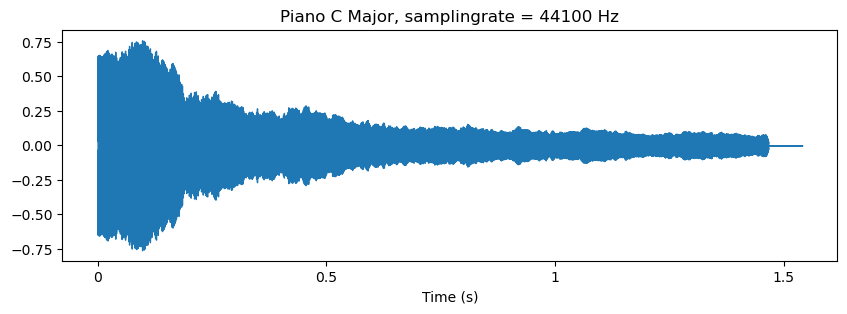

In [2]:
#Define audio directory
BASE_DIR = "E:/Dataset/Signal Processing/Piano/"
nama_file = "piano_C_major.wav"

# Load audio data using load from librosa
# Return audio time series and sampling rate of audio  
piano_C, sr_C = lb.load(os.path.join(BASE_DIR, nama_file), sr = None, mono = True)

# Visualize a waveform in the time domain using waveshow
fig = plt.figure(figsize = (10,3))
waveshow(piano_C, sr = sr_C, x_axis='s')
plt.title('Piano C Major, samplingrate = ' + str(sr_C) + ' Hz')

In [3]:
# You can play the audio using IPython
Audio(data = piano_C, rate = sr_C)

### *Pre-emphasize*

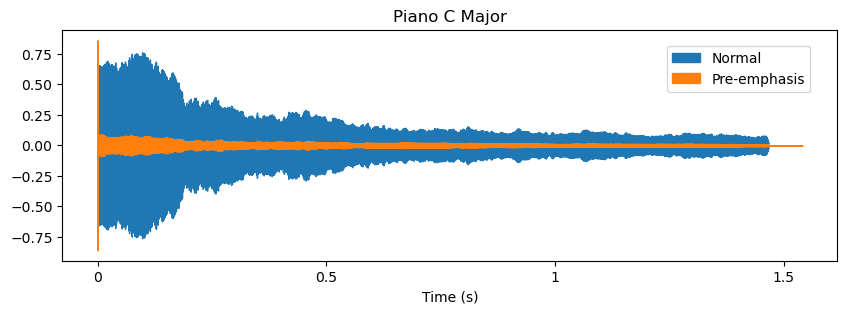

In [4]:
# Pre-emphasize using function preemphasis from librosa
# y are audio signal
# coef are pre-emphasize coefficient (between 0 and 1) mostly use 0.95 or 0.97
emphasized_signal = lb.effects.preemphasis(y = piano_C, coef = 0.97)

# Visualize waveform audio signal before and after pre-emphasize
fig = plt.figure(figsize = (10,3))
waveshow(piano_C, sr = sr_C, x_axis='s', label = 'Normal')
waveshow(emphasized_signal, sr = sr_C, x_axis='s', label = 'Pre-emphasis')
plt.title('Piano C Major')
fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.85))

### *Frame Blocking*

In [5]:
# Create a function to process frame size and overlap before send it to frame function from librosa
# Because function frame from librosa only accept integer value 
def frame_blocking(emphasized_signal, frame_size, overlap, sr):
    hop_size = overlap * frame_size #Convert from percentage to miliseconds
    frame_length, hop_length = frame_size * sr, hop_size * sr #Convert from miliseconds to samples
    frame_length = int(frame_length) # Round from float to integer
    hop_length = int(hop_length) # Round from float to integer
    
    frames = lb.util.frame(emphasized_signal, frame_length = frame_length, hop_length = hop_length, axis = 0)
    
    return frames, frame_length, hop_length

# In the following example we use frame_size = 0.025 ms and overlapping = 50%
frames, frame_length, hop_length = frame_blocking(emphasized_signal, 0.025, 0.5, sr_C)

In [6]:
# Print information about frames
print(f"There are {len(frames)} frames")
print(f"There are {len(frames[0])} data or samples within frame")

There are 122 frames
There are 1102 data or samples within frame


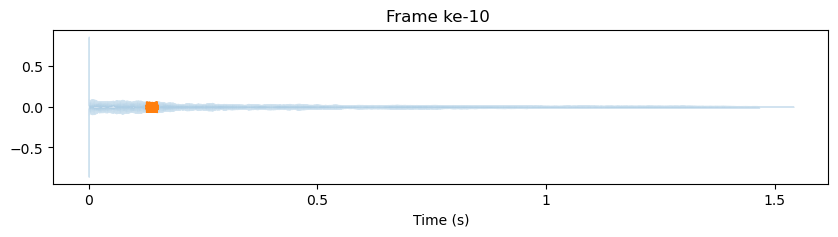

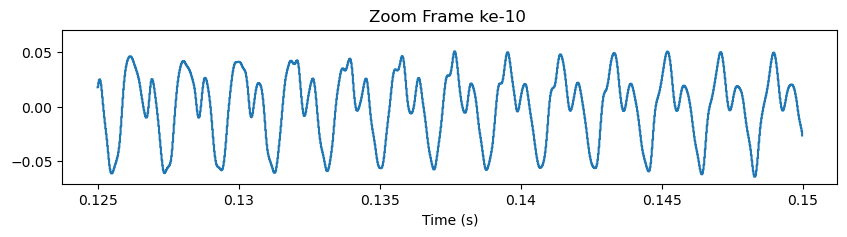

In [7]:
# Visualize certain frame from whole frame
def plot_frame(y, sr, frames, selected_frame, frame_size, overlap, plot_title = ''):
    hop_size = overlap * frame_size #Convert from percentage to miliseconds
    offset = hop_size * selected_frame

    plt.figure(figsize = (10,2))
    lb.display.waveshow(y, sr=sr, alpha=0.2, marker='.', label='Full signal', x_axis='s')
    lb.display.waveshow(frames, sr=sr, offset=offset, x_axis='s')
    plt.title('Frame ke-' + str(selected_frame) + ' ' + plot_title)

# Zooming frame and plot it
def zoom_frame(sr, frames, selected_frame, frame_size, overlap, plot_title):
    hop_size = overlap * frame_size #Convert from percentage to miliseconds
    offset = hop_size * selected_frame
    
    plt.figure(figsize = (10,2))
    lb.display.waveshow(frames, sr=sr, offset=offset, x_axis='s')
    plt.title('Zoom Frame ke-' + str(selected_frame) + ' ' + plot_title)

# In this following example we gonna visualize 10th frames
plot_frame(emphasized_signal, sr_C, frames[10], 10, 0.025, 0.5, plot_title = '')
zoom_frame(sr_C, frames[10], 10, 0.025, 0.5, plot_title = '')

### *Windowing*

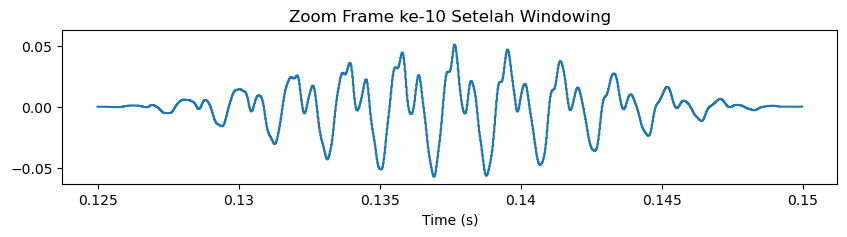

In [8]:
# Windowing all signals within frame using hanning from numpy
window_signal = frames * np.hanning(frame_length)

# Visualize 10th frames after windowing
zoom_frame(sr_C, window_signal[10], 10, 0.025, 0.5, plot_title = 'Setelah Windowing')

### *Discrete Fourier Transform* using *Short-Time Fourier Transform*

In [9]:
# The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.
# Compute STFT using function stft from librosa
# y are input signal, hop_length are number of audio samples between adjacent STFT columns
# window are a window function such as hann, n_fft are length of the windowed signal after padding with zeros
# center are padding protocol
# lb.stft return complex-valued matrix (magnitude and phase) of short-term Fourier transform coefficients.
audio_stft = lb.stft(y=emphasized_signal, hop_length=hop_length, 
                     window='hann', n_fft = frame_length, center=False)

# We are gonna remove the phase because we didn't need it
mag_only = (np.abs(audio_stft))

In [10]:
# Print 
print(f"There are {len(audio_stft)} frequency bins")
print(f"There are {len(audio_stft[0])} frames within frequency bin")
print("This is an example output of STFT for first frequency bin and first frame: ")
print(audio_stft[0][0])
print("This is an example output of magnitude only for first frequency bin and first frame: ")
print(mag_only[0][0])

There are 552 frequency bins
There are 122 frames within frequency bin
This is an example output of STFT for first frequency bin and first frame: 
(-0.19054754+0j)
This is an example output of magnitude only for first frequency bin and first frame: 
0.19054754


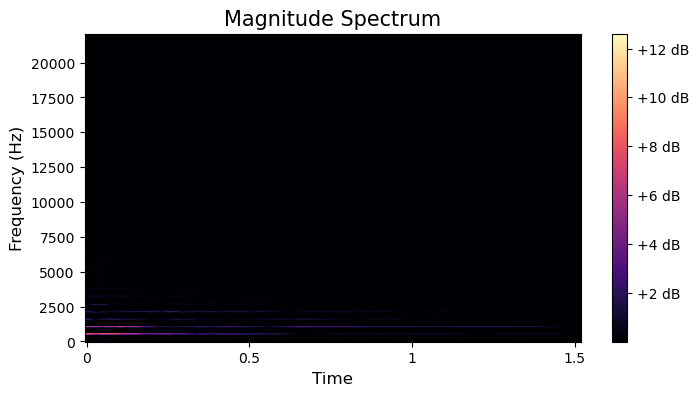

In [11]:
# Visualize magnitude spectrum using specshow from librosa
def plot_spectrogram(magnitude_spectrum, sr, hop_length, compute):
    fig_spectrogram = plt.figure(figsize = (8,4))
    img = lb.display.specshow(magnitude_spectrum, sr=sr, hop_length=hop_length,
                                x_axis='time', y_axis=compute, fmax=8000, cmap = 'magma')
    plt.title('Magnitude Spectrum', fontdict=dict(size=15))
    plt.xlabel('Time', fontdict=dict(size=12))
    plt.ylabel('Frequency (Hz)', fontdict=dict(size=12))
    fig_spectrogram.colorbar(img, format="%+2.f dB")

plot_spectrogram(mag_only, sr_C, hop_length, 'linear')

### *Mel-Scaled Filterbank*

In [12]:
# Before compute mel-scaled, first we square the magnitude only 
power = (mag_only)**2

# Mel-scaled filterbank using melspectrogram from librosa
# n_mels are number of mel bands to generate
mel_signal = lb.feature.melspectrogram(S = power, sr=sr_C, n_mels=64)

# Convert from powerspectrogram to decibel
log_mel = lb.power_to_db(mel_signal)

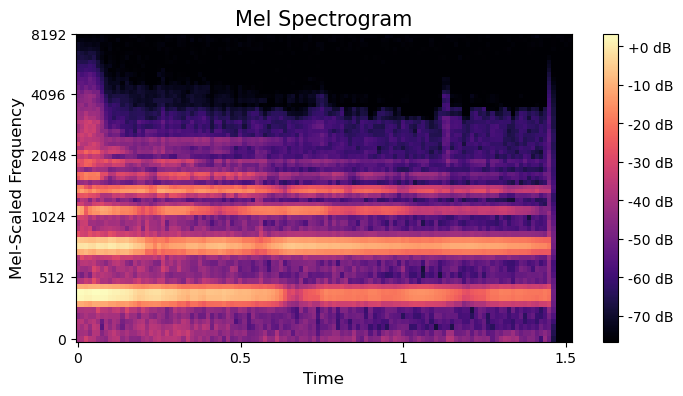

In [13]:
# Visualize melspectrogram using specshow from librosa
# y_axis change to mel
def plot_melspec(melspec, hop_length, sr):
    fig_melspec = plt.figure(figsize = (8,4))
    img = lb.display.specshow(melspec, sr=sr, hop_length=hop_length,
                                x_axis='time', y_axis='mel', fmax=8000, cmap = 'magma')
    plt.title('Mel Spectrogram', fontdict=dict(size=15))
    plt.xlabel('Time', fontdict=dict(size=12))
    plt.ylabel('Mel-Scaled Frequency', fontdict=dict(size=12))
    fig_melspec.colorbar(img, format="%+2.f dB")

plot_melspec(log_mel, hop_length, sr_C)

### *Discrete Cosine Transform*

In [15]:
# Compute MFCC
# S are log-power Mel spectrogram
# n_mfcc are number of Mel-Frequency Cepstral Coefficient
mfcc = lb.feature.mfcc(S=log_mel, n_mfcc=24)

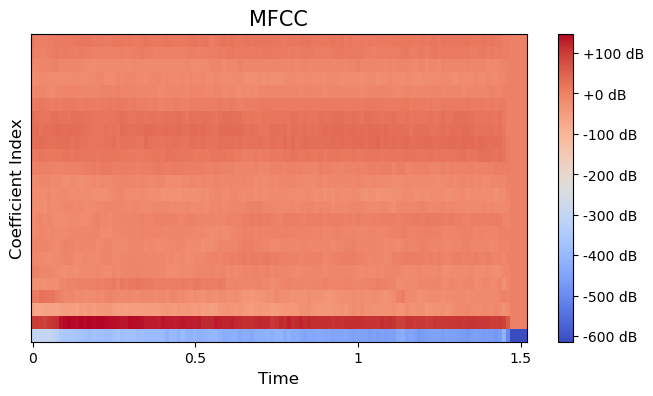

In [16]:
# Visualize MFCC
def plot_mfcc(mfcc, sr, hop_length):
    fig_mfcc = plt.figure(figsize = (8,4))
    img = lb.display.specshow(mfcc, sr=sr, hop_length=hop_length, x_axis='time')
    plt.title('MFCC', fontdict=dict(size=15))
    plt.xlabel('Time', fontdict=dict(size=12))
    plt.ylabel('Coefficient Index', fontdict=dict(size=12))
    fig_mfcc.colorbar(img, format="%+2.f dB")

plot_mfcc(mfcc, sr_C, hop_length)